In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)
import shared_utils

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt

import importlib
import rt_analysis as rt
import rt_filter_map_plot

from IPython.display import display, Markdown, Latex, HTML
import json

from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

In [2]:
itp_id = 4 ## AC Transit

In [3]:
import numpy as np

In [4]:
date_range = np.arange('2022-04-30', '2022-05-09', dtype='datetime64[D]')

In [5]:
date_range

array(['2022-04-30', '2022-05-01', '2022-05-02', '2022-05-03',
       '2022-05-04', '2022-05-05', '2022-05-06', '2022-05-07',
       '2022-05-08'], dtype='datetime64[D]')

# Generate analysis data for all dates

In [6]:
pbar = tqdm()

0it [00:00, ?it/s]

In [7]:
# for date in date_range:
#     date = date.astype(dt.date)
#     try:
#         rt_analysis = rt.OperatorDayAnalysis(itp_id, date, pbar)
#         rt_analysis.export_views_gcs()
#         print(f'complete for date: {date}')
#     except:
#         print(f'failed for date: {date}')
#         continue

In [8]:
# for date in date_range:
#     date = date.astype(dt.date)
#     try:
#         rt_day = rt_filter_map_plot.from_gcs(itp_id, date)
#         print(f'complete for date: {date}')
#     except:
#         print(f'failed for date: {date}')
#         continue

In [128]:
rt_day = rt_filter_map_plot.from_gcs(4, dt.date(2022, 5, 4))

found parquet


In [20]:
rt_day.stop_delay_view.dropna(subset=['stop_id']) >> head(3)

,shape_meters,stop_id,stop_name,geometry,shape_id,trip_key,trip_id,stop_sequence,arrival_time,route_id,route_short_name,direction_id,actual_time,delay_seconds
0,16980.695427,4046,Pierce St & Central Av,POINT (-202802.979 -10390.747),shp-LA-61,-7.742120e+18,7121020,9.0,2022-05-04 08:12:00,LA,LA,0,2022-05-04 08:17:25.006131,325.0
1,17258.544947,4047,Pierce St & Pacific East Mall,POINT (-202762.734 -10653.381),shp-LA-61,-7.742120e+18,7121020,10.0,2022-05-04 08:12:51,LA,LA,0,2022-05-04 08:18:07.594638,316.0
2,17553.054805,222,545 Pierce St,POINT (-202679.620 -10934.183),shp-LA-61,-7.742120e+18,7121020,11.0,2022-05-04 08:13:34,LA,LA,0,2022-05-04 08:19:14.363276,340.0


In [21]:
corridor = gpd.read_file('./CMCP_StudyAreaBoundary.geojson').to_crs(shared_utils.geography_utils.CA_NAD83Albers)

In [22]:
to_clip = rt_day.stop_delay_view.drop_duplicates(subset=['shape_id', 'stop_sequence']).dropna(subset=['stop_id'])

In [23]:
clipped = to_clip.clip(corridor)

In [24]:
shape_seqences = (rt_day.stop_delay_view.dropna(subset=['stop_id']) >> distinct(_.shape_id, _.stop_sequence) >> arrange(_.shape_id, _.stop_sequence))

In [25]:
stops_per_shape = shape_seqences >> group_by(_.shape_id) >> summarize(n_stops = _.shape_id.size)

# can use this as # of stops in corr...
stops_in_corr = clipped >> group_by(_.shape_id) >> summarize(in_corr = _.shape_id.size)
stop_comparison = stops_per_shape >> inner_join(_, stops_in_corr, on='shape_id')

In [26]:
stop_comparison = stop_comparison >> mutate(corr_shape = _.in_corr > _.n_stops / 2)

In [27]:
corr_shapes = stop_comparison >> filter(_.corr_shape)

In [28]:
shape_sequence_filter = {}
for shape_id in corr_shapes.shape_id.unique():
# for shape_id in ['shp-10-09']:
    shape_sequence_filter[shape_id] = {}
    clipped_min = (clipped >> filter(_.shape_id == shape_id)).stop_sequence.min()
    clipped_max = (clipped >> filter(_.shape_id == shape_id)).stop_sequence.max()
    this_shape = shape_seqences >> filter(_.shape_id == shape_id)
    filter_min = (this_shape >> filter(_.stop_sequence < clipped_min)).stop_sequence.max()
    filter_max = (this_shape >> filter(_.stop_sequence > clipped_max)).stop_sequence.min()
    shape_sequence_filter[shape_id]['min'] = max(0, filter_min)
    shape_sequence_filter[shape_id]['max'] = filter_max if not np.isnan(filter_max) else clipped_max

In [29]:
shape_sequence_filter

{'shp-10-09': {'min': 0, 'max': 33.0},
 'shp-10-10': {'min': 0, 'max': 35.0},
 'shp-1T-04': {'min': 0, 'max': 32.0},
 'shp-1T-05': {'min': 0, 'max': 32.0},
 'shp-1T-51': {'min': 2.0, 'max': 33.0},
 'shp-40-18': {'min': 0, 'max': 67.0},
 'shp-40-19': {'min': 8.0, 'max': 34.0},
 'shp-40-63': {'min': 2.0, 'max': 73.0},
 'shp-40-65': {'min': 2.0, 'max': 30.0},
 'shp-41-54': {'min': 0, 'max': 26.0},
 'shp-45-04': {'min': 12.0, 'max': 52.0},
 'shp-45-53': {'min': 4.0, 'max': 43.0},
 'shp-73-01': {'min': 6.0, 'max': 19.0},
 'shp-73-51': {'min': 4.0, 'max': 17.0},
 'shp-801-01': {'min': 36.0, 'max': 84.0},
 'shp-801-62': {'min': 0, 'max': 52.0},
 'shp-840-11': {'min': 8.0, 'max': 35.0},
 'shp-840-52': {'min': 3.0, 'max': 32.0},
 'shp-90-02': {'min': 0, 'max': 14.0},
 'shp-90-54': {'min': 11.0, 'max': 22.0}}

In [20]:
# gdf = rt_day.stop_delay_view >> filter(_.shape_id == 'shp-40-19', _.stop_sequence >= 8, _.stop_sequence <= 34)
# gdf = gdf[['stop_id', 'geometry']]

# pd.concat([corridor, gdf]).explore(tiles = "CartoDB positron")

# Algorithm

* Clip stops to corridor
* Get first and last stops in corridor for each shape_id, then find 1 stop before and 1 stop after for each
* Filter stop_delay_view based on those stops
* Assert that more than 50% of filtered stops within corridor, if not then drop shape (remove shapes starting/ending in corridor but mostly running outside)

In [30]:
# rt_day.segment_speed_map()

In [31]:
fn = lambda x: x.shape_id in (shape_sequence_filter.keys()) and x.stop_sequence >= shape_sequence_filter[x.shape_id]['min'] and x.stop_sequence <= shape_sequence_filter[x.shape_id]['max']
rt_day.stop_delay_view['corridor'] = rt_day.stop_delay_view.apply(fn, axis=1)

In [32]:
mappable_stops = (rt_day.stop_delay_view
                  >> distinct(_.shape_id, _.stop_sequence, _keep_all=True)
                  >> filter(_.corridor)
                  >> select(_.stop_id, _.geometry, _.stop_sequence)
                 )

In [137]:
# pd.concat([mappable_stops, corridor]).explore(tiles = "CartoDB positron")

In [34]:
corridor_filtered = rt_day.stop_delay_view >> filter(_.corridor)

In [35]:
corridor_filtered >> head(3)

,shape_meters,stop_id,stop_name,geometry,shape_id,trip_key,trip_id,stop_sequence,arrival_time,route_id,route_short_name,direction_id,actual_time,delay_seconds,corridor
1,16799.127827,1705,Mission Blvd & Valle Vista Av,POINT (-180779.919 -40564.553),shp-801-01,-7.830714e+18,3755020,37.0,2022-05-05 00:25:58,801,801,1,2022-05-05 00:30:12.065927,254.0,True
2,25952.704633,4895,Mission Blvd & Blossom Way,POINT (-184562.968 -35144.658),shp-801-01,-7.830714e+18,3755020,57.0,2022-05-05 00:46:03,801,801,1,2022-05-05 00:47:09.069803,66.0,True
3,18174.961952,1702,Mission Blvd & Tennyson Rd,POINT (-181050.555 -40228.006),shp-801-01,-7.830714e+18,3755020,39.0,2022-05-05 00:29:18,801,801,1,2022-05-05 00:33:12.577286,234.0,True


In [36]:
first_stops = corridor_filtered >> group_by(_.trip_id) >> summarize(stop_sequence = _.stop_sequence.min())

In [37]:
entry_delays = (first_stops
                >> inner_join(_, corridor_filtered, on = ['trip_id', 'stop_sequence'])
                >> select(_.trip_id, _.delay_seconds)
                >> rename(entry_delay_seconds = _.delay_seconds)
               )

In [38]:
entry_delays >> head(3)

,trip_id,entry_delay_seconds
0,10003020,259.0
1,10026020,16.0
2,10028020,164.0


In [39]:
with_entry_delay = corridor_filtered >> inner_join(_, entry_delays, on='trip_id')
with_entry_delay = with_entry_delay >> mutate(corridor_delay_seconds = _.delay_seconds - _.entry_delay_seconds)
with_entry_delay >> head(3)

,shape_meters,stop_id,stop_name,geometry,shape_id,trip_key,trip_id,stop_sequence,arrival_time,route_id,route_short_name,direction_id,actual_time,delay_seconds,corridor,entry_delay_seconds,corridor_delay_seconds
0,16799.127827,1705,Mission Blvd & Valle Vista Av,POINT (-180779.919 -40564.553),shp-801-01,-7.830714e+18,3755020,37.0,2022-05-05 00:25:58,801,801,1,2022-05-05 00:30:12.065927,254.0,True,291.0,-37.0
1,25952.704633,4895,Mission Blvd & Blossom Way,POINT (-184562.968 -35144.658),shp-801-01,-7.830714e+18,3755020,57.0,2022-05-05 00:46:03,801,801,1,2022-05-05 00:47:09.069803,66.0,True,291.0,-225.0
2,18174.961952,1702,Mission Blvd & Tennyson Rd,POINT (-181050.555 -40228.006),shp-801-01,-7.830714e+18,3755020,39.0,2022-05-05 00:29:18,801,801,1,2022-05-05 00:33:12.577286,234.0,True,291.0,-57.0


array([[<AxesSubplot:title={'center':'corridor_delay_seconds'}>]],
      dtype=object)

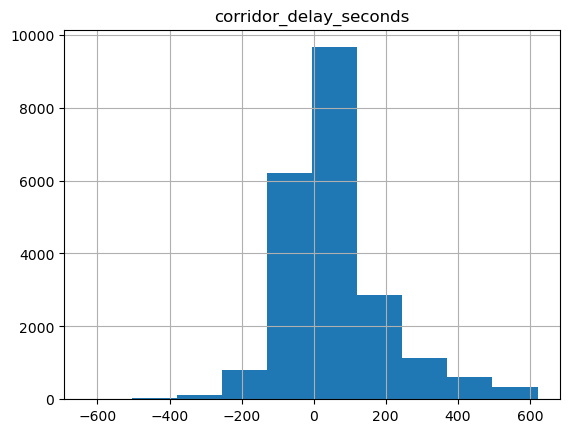

In [40]:
(with_entry_delay >> filter(_.corridor_delay_seconds < _.corridor_delay_seconds.quantile(.99))).hist(column='corridor_delay_seconds')

In [41]:
with_entry_delay >> summarize(median_corridor_delay_seconds = _.corridor_delay_seconds.median())

,median_corridor_delay_seconds
0,8.0


In [42]:
with_entry_delay >> group_by(_.trip_id) >> summarize(median_corridor_delay_seconds = _.corridor_delay_seconds.median())

,trip_id,median_corridor_delay_seconds
0,10003020,62.0
1,10026020,47.0
2,10028020,4.0
3,10034020,-10.0
4,10037020,-36.5
...,...,...
733,9918020,0.0
734,9946020,0.0
735,9960020,186.5
736,9975020,-1.0


array([[<AxesSubplot:title={'center':'median_corridor_delay_seconds'}>]],
      dtype=object)

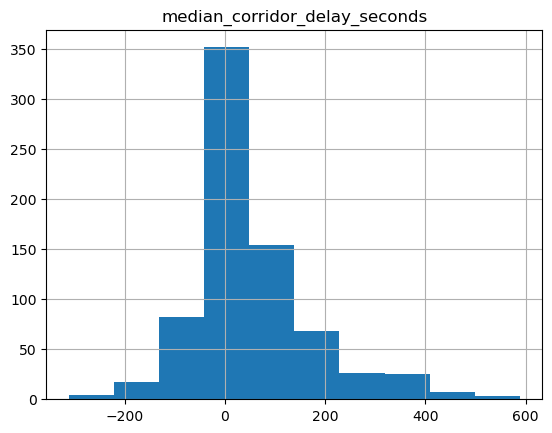

In [43]:
(with_entry_delay >> group_by(_.trip_id) >> summarize(median_corridor_delay_seconds = _.corridor_delay_seconds.median())).hist(column='median_corridor_delay_seconds')

In [44]:
(with_entry_delay
 >> group_by(_.trip_id)
 >> summarize(median_corridor_delay_seconds = _.corridor_delay_seconds.median())
 >> summarize(sum_of_medians = _.median_corridor_delay_seconds.sum())
)

,sum_of_medians
0,36585.5


# Report:

* Sum of median trip delays
* Median segment speed
* Delay compared to speed standards: 14mph local/ 20mph BRT (find some citation)

# Speed-based Metrics

In [129]:
importlib.reload(rt_filter_map_plot)

<module 'rt_filter_map_plot' from '/home/jovyan/data-analyses/rt_delay/rt_filter_map_plot.py'>

In [130]:
rt_day.reset_filter()

In [132]:
m = rt_filter_map_plot.RtFilterMapper.segment_speed_map(rt_day)

shp-LA-61
shp-LA-12
shp-672-51
shp-667-06
shp-675-03
shp-G-54
shp-79-55
shp-12-14
shp-631-51
shp-200-15
shp-801-01
shp-99-10
shp-604-14
shp-851-57
shp-605-01
shp-36-08
shp-51B-16
shp-51B-17
shp-6-59
shp-21-56
shp-21-22
shp-OX-53
shp-OX-03
shp-631-03
shp-631-52
shp-631-02
shp-687-01
shp-687-51
shp-76-09
shp-669-57
shp-L-06
shp-34-56
shp-35-61
shp-216-62
shp-NX3-07
shp-57-62
shp-680-53
shp-98-02
shp-86-01
shp-29-34
shp-29-61
shp-29-63
shp-56-03
shp-210-07
shp-19-16
shp-29-33
shp-29-30
shp-20-18
shp-88-09
shp-801-62
shp-99-09
shp-71-03
shp-667-56
shp-667-52
shp-376-09
shp-800-A2
shp-72M-40
shp-72M-42
shp-74-01
shp-72-79
shp-72-73
shp-72-78
shp-800-81
shp-72M-61
shp-28-59
shp-62-58
shp-96-58
shp-216-16
shp-625-01
shp-625-02
shp-70-05
shp-39-53
shp-653-01
shp-14-15
shp-805-60
shp-73-01
shp-62-09
shp-93-09
shp-33-14
shp-33-68
shp-851-13
shp-51A-17
shp-663-06
shp-20-03
shp-W-07
shp-74-56
shp-97-57
shp-18-19
shp-655-03
shp-54-03
shp-7-10
shp-200-60
shp-NX3-06
shp-21-23
shp-21-20
shp-65-11
shp-

In [135]:
# m

# Speed Calc

In [134]:
rt_day.stop_segment_speed_view >> filter(_.corridor) >> head(5)

AttributeError: 'GeoDataFrame' object has no attribute 'corridor'

In [ ]:
rt_day.stop_segment_speed_view >> filter(_.corridor) >> mutate(median_mph = _.speed_mph.median()) >> head(3)